# Couple of differential equations and deep learning

Now we will apply UDE 
$$\left\{
\begin{aligned}
	& I' = \gamma \mathrm{NeuralNetwork}_{\theta}(t,I) I  -\gamma I,\\
	& \mathcal{R}_t = \mathrm{NeuralNetwork}_{\theta}(t,I),
\end{aligned}
\right.$$
to learn effective reproduction number from the data generated by logistic model
$$
	\left\{
	\begin{aligned}
		& I' = 0.2\left(1-\frac{I}{30}\right)I,\\
		& \mathcal{R}_t = 3-\frac{I}{15}.
	\end{aligned}
	\right.
$$

For detail on mathematics, one can see 
- Song P, Xiao Y. Estimating time-varying reproduction number by deep learning techniques[J]. J Appl Anal Comput, 2022, 12(3): 1077-1089.

## IMPORTANT: Activate Julia environment first

In [40]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/MyProjects/Julia_Tutorial_on_AI4MathBiology`


## Loading packages and setting random seeds

In [41]:
##
using Lux, DiffEqFlux, DifferentialEquations, Optimization, OptimizationOptimJL, Random, Plots
using DataFrames
using CSV
using ComponentArrays
using OptimizationOptimisers
using Flux
using Plots
using LaTeXStrings
rng = Random.default_rng()
Random.seed!(1);

## Generating test data from logistic model

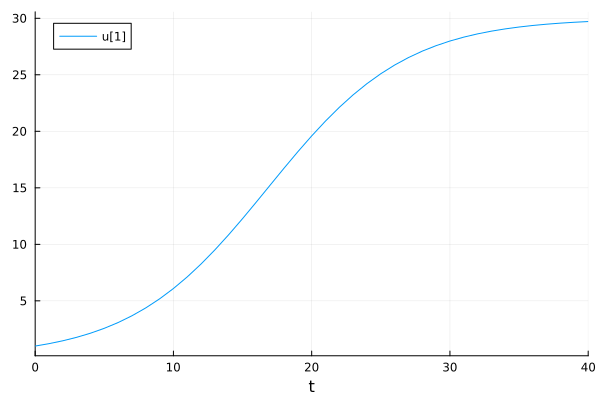

In [42]:
function model2(du, u, p, t)
    r, α = p
    du .= r .* u .* (1 .- u ./ α)
end
u_0 = [1.0]
p_data = [0.2, 30]
tspan_data = (0.0, 30)
prob_data = ODEProblem(model2, u_0, tspan_data, p_data)
data_solve = solve(prob_data, Tsit5(), abstol=1e-12, reltol=1e-12, saveat=1)
data_withoutnois = Array(data_solve)
data = data_withoutnois #+ Float32(2e-1)*randn(eltype(data_withoutnois), size(data_withoutnois))
tspan_predict = (0.0, 40)
prob_predict = ODEProblem(model2, u_0, tspan_predict, p_data)
test_data = solve(prob_predict, Tsit5(), abstol=1e-12, reltol=1e-12, saveat=1)
plot(test_data)

## Define neural ODE

In [43]:
ann_node = Lux.Chain(Lux.Dense(1, 10, tanh), Lux.Dense(10, 1))
p, st = Lux.setup(rng, ann_node)
function model2_nn(du, u, p, t)
    du[1] = 0.1 * ann_node([t], p, st)[1][1] * u[1] - 0.1 * u[1]
end
prob_nn = ODEProblem(model2_nn, u_0, tspan_data, ComponentArray(p))
function train(θ)
    Array(concrete_solve(prob_nn, Tsit5(), u_0, θ, saveat=1,
        abstol=1e-6, reltol=1e-6))#,sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
println(train(p))

[1.0 0.9034894787099034 0.816044774397625 0.738899351409905 0.6708651886632545 0.6103115066683285 0.5559385598217129 0.5068149611814299 0.4622628182958812 0.42176265541056185 0.3848926876528822 0.3512970955937428 0.32066653678690593 0.29272805069240965 0.26723762578981225 0.24397614107566593 0.22274549717364528 0.20336636216455103 0.1856759316563355 0.16952606292369218 0.15478209579983565 0.1413211771011583 0.1290313774034772 0.11781071855307523 0.10756598871265088 0.09821226053652148 0.08967204625628192 0.08187447835954895 0.07475499024165028 0.06825465263126726 0.062319547374091934]


## Define Loss functions and Callbacks

In [44]:
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end

const losses = []
callback(θ, l, pred) = begin
    push!(losses, l)
    if length(losses) % 100 == 0
        println(losses[end])
    end
    false
end

pinit = ComponentArray(p)
println(loss(p))
callback(pinit, loss(pinit)...)

(8216.907972450199, [1.0 0.9034894787099034 0.816044774397625 0.738899351409905 0.6708651886632545 0.6103115066683285 0.5559385598217129 0.5068149611814299 0.4622628182958812 0.42176265541056185 0.3848926876528822 0.3512970955937428 0.32066653678690593 0.29272805069240965 0.26723762578981225 0.24397614107566593 0.22274549717364528 0.20336636216455103 0.1856759316563355 0.16952606292369218 0.15478209579983565 0.1413211771011583 0.1290313774034772 0.11781071855307523 0.10756598871265088 0.09821226053652148 0.08967204625628192 0.08187447835954895 0.07475499024165028 0.06825465263126726 0.062319547374091934])


false

## Train the DNN embedded in differential equations

In [45]:
##
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

result_neuralode = Optimization.solve(optprob,
    OptimizationOptimisers.ADAM(0.01),
    callback=callback,
    maxiters=3000)

351.3882444818854


10.717546698923622
5.085851488814772


3.309161988025375


2.047732114123806


1.4779429126053438


1.1030499970359096
0.8671407377062605


0.89452740171059
1.1183121854553197


0.5708184017763677
0.6691065208401739


5.132183889809579


0.37482373305669753


0.34152053487660833


0.3957727120735596
0.45823548822468946


0.6362163059886281
0.5308457201849255


0.38457406727826243
0.3170416291552578


0.24499973482324744


0.2588192487633485


0.2888203122058308


0.2505142252862214
0.32557412313084977


0.21740930062101116
0.22007704827398192


0.27991144946026614
0.36140008308087385


retcode: Default
u: ComponentVector{Float32}(layer_1 = (weight = Float32[-0.07485764; -0.8849845; … ; 0.6581717; 0.06597537;;], bias = Float32[1.2210366; -0.25018442; … ; 0.08555885; -0.9714211;;]), layer_2 = (weight = Float32[0.24699448 -0.5477573 … -0.006901356 -0.44552884], bias = Float32[0.09773029;;]))

## Output and data visulization

(layer_1 = (weight = Float32[-0.07485764; -0.8849845; -0.91284543; -0.052147113; -0.96092546; 0.5507915; -0.0682303; 0.45291868; 0.6581717; 0.06597537;;], bias = Float32[1.2210366; -0.25018442; -0.25013623; 0.3748877; -0.25796017; 0.25077668; 1.040233; 0.25534686; 0.08555885; -0.9714211;;]), layer_2 = (weight = Float32[0.24699448 -0.5477573 -0.5507935 0.47983858 -0.26715246 0.50550157 0.354054 0.3404353 -0.006901356 -0.44552884], bias = Float32[0.09773029;;]))


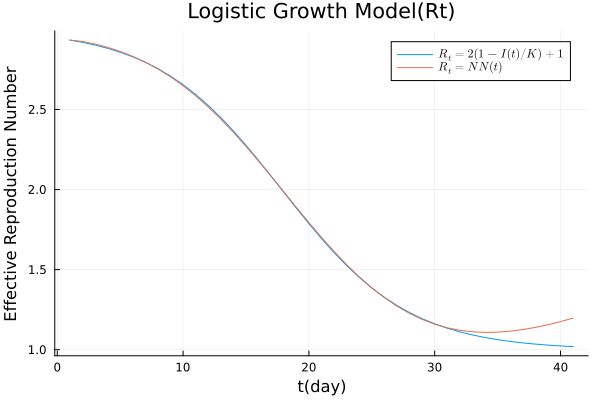

In [46]:
pfinal = result_neuralode.u

println(pfinal)
prob_nn2 = ODEProblem(model2_nn, u_0, tspan_predict, pfinal)
s_nn = solve(prob_nn2, Tsit5(), saveat=1)

# I(t)
scatter(data_solve.t, data[1, :], label="Training Data")
plot!(test_data, label="Real Data")
plot!(s_nn, label="Neural Networks")
xlabel!("t(day)")
ylabel!("I(t)")
title!("Logistic Growth Model(I(t))")
#savefig("Figures/logisticIt.png")
# R(t)
f(x) = 2 * (1 - x / p_data[2]) + 1
plot((f.(test_data))', label=L"R_t = 2(1-I(t)/K)+1")
plot!((f.(s_nn))', label=L"R_t = NN(t)")
xlabel!("t(day)")
ylabel!("Effective Reproduction Number")
title!("Logistic Growth Model(Rt)")
#savefig("Figures/logisticRt.png")

### Question: modify the codes, change `Lux.jl` back to `Flux.jl`?